
NH₃ - Graph-Based Equivariant QML
Strategy: Encode N-H bonds as graph edges, simple circuit

Data: 2400 configurations
Positions shape: (2400, 4, 3)
Forces shape: (2400, 4, 3)

Energy range: [-1.0000, 1.0000]
Energy scaled: [-1.0000, 1.0000]
Forces range: [-162.1456, 140.4216]
Forces scaled: [-1.0000, 1.0000]

Train: 1920, Test: 480

PHASE 1: Training ENERGY only

  Step    0 | Train: 17.906826 | Test: 16.874539 | GradNorm: 10.0000
  Step   25 | Train: 0.124873 | Test: 0.112121 | GradNorm: 0.4757
  Step   50 | Train: 0.133163 | Test: 0.125700 | GradNorm: 0.2291
  Step   75 | Train: 0.125858 | Test: 0.112424 | GradNorm: 0.1563
  Step  100 | Train: 0.117866 | Test: 0.108902 | GradNorm: 0.0810
  Step  125 | Train: 0.113464 | Test: 0.106928 | GradNorm: 0.0590
  Step  150 | Train: 0.110872 | Test: 0.105686 | GradNorm: 0.0463
  Step  175 | Train: 0.109138 | Test: 0.104756 | GradNorm: 0.0387
  Step  200 | Train: 0.107801 | Test: 0.103881 | GradNorm: 0.0340
  Step  225 | Train: 0.106658 | Tes

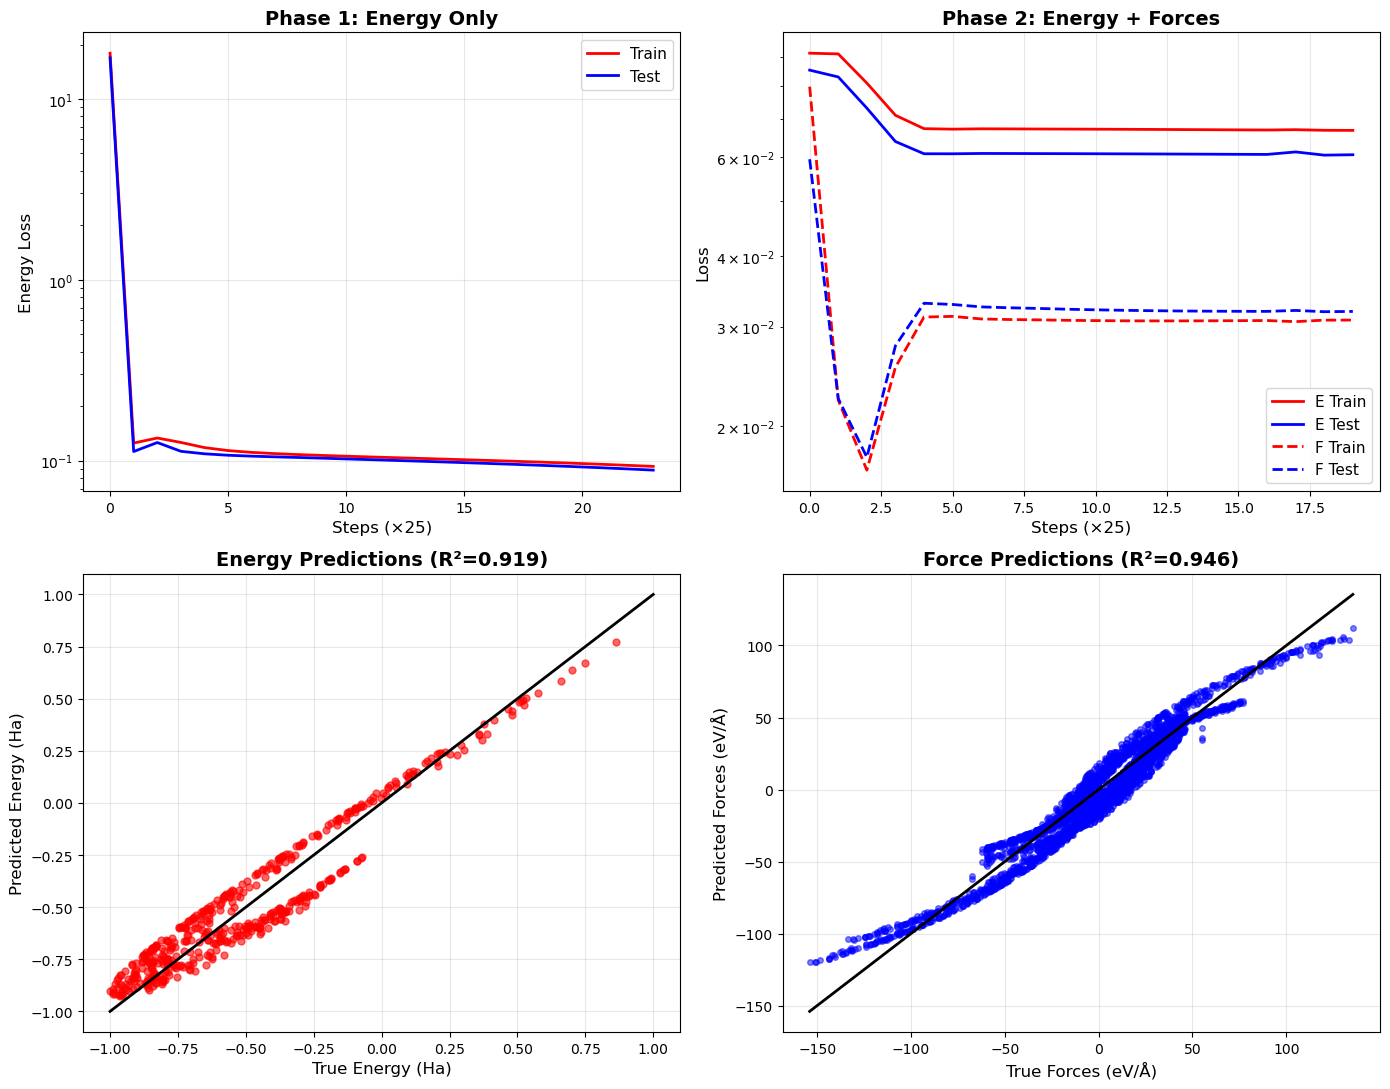

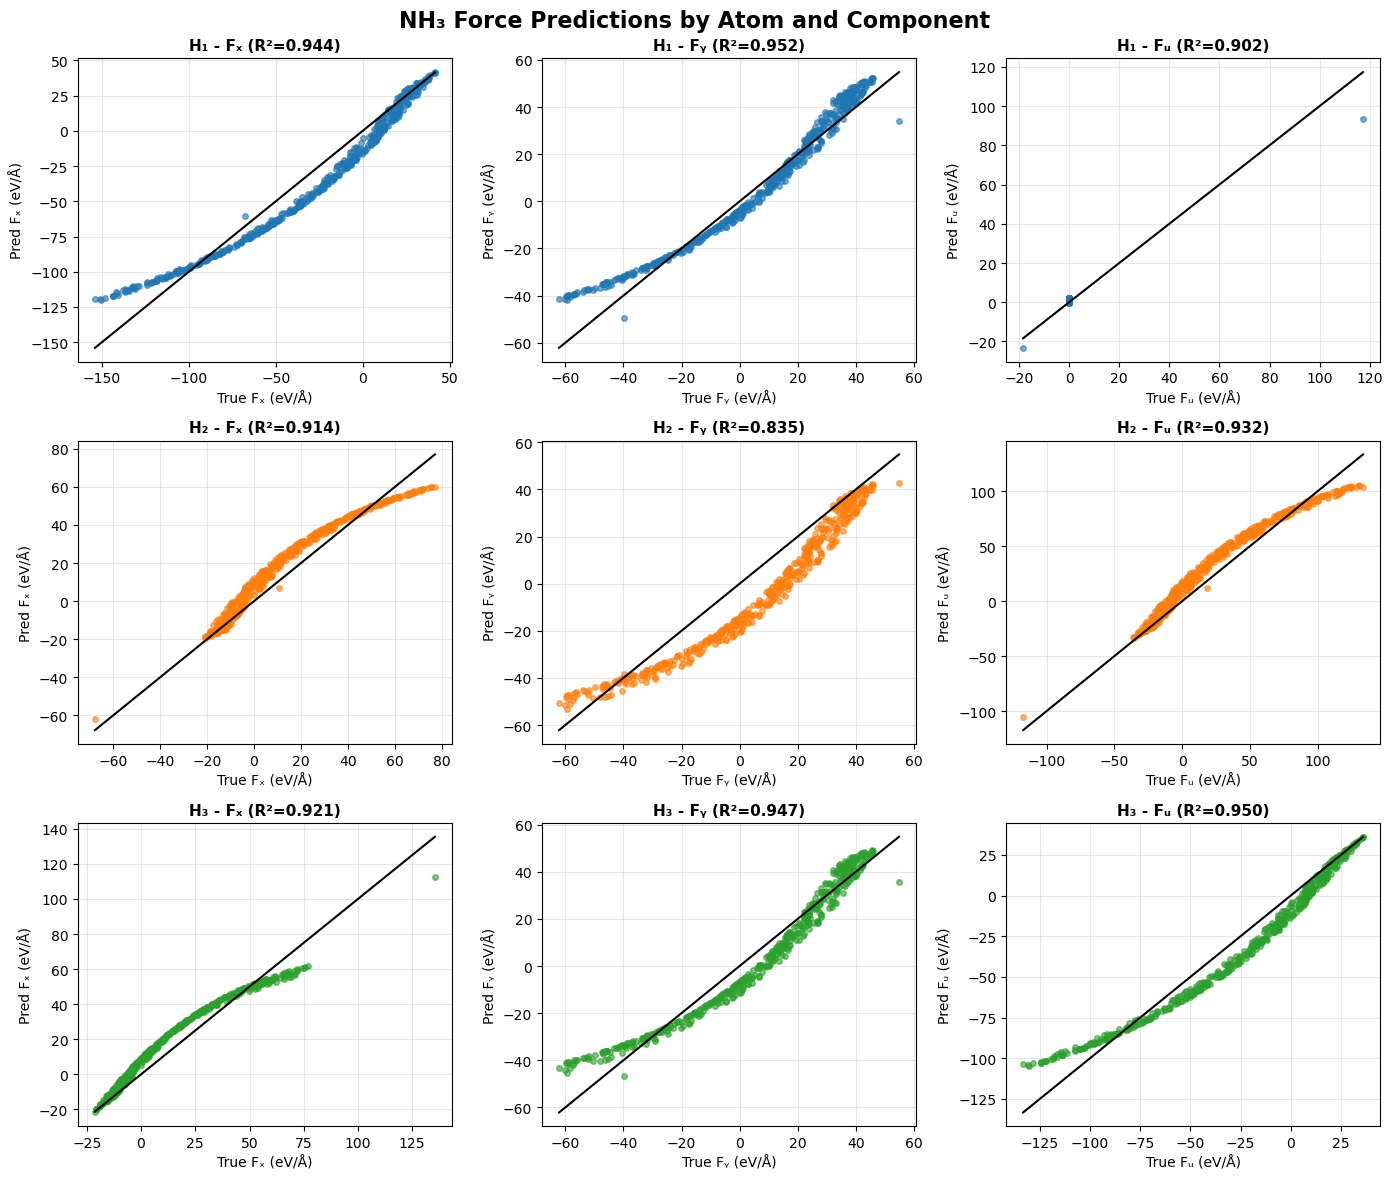


✓ Graph-based equivariant QML for NH₃ complete!
✓ Two-phase training: energy first, then forces
✓ Graph encoding: N-H bonds as edges with geometric features
✓ Predictions for all force components on all H atoms


In [4]:
import pennylane as qml
import numpy as np

import jax
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

from jax import numpy as jnp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

#############################################################################################
# GRAPH-BASED EQUIVARIANT QML FOR NH3
# Strategy: Encode molecular graph structure with N-H bonds
#############################################################################################

print(f"\n{'='*70}")
print(f"NH₃ - Graph-Based Equivariant QML")
print(f"{'='*70}")
print(f"Strategy: Encode N-H bonds as graph edges, simple circuit")
print(f"{'='*70}\n")

# NH3: 1 N atom + 3 H atoms = 4 atoms
# Graph structure: N at center, 3 edges to H atoms
# We'll use 6 qubits: 2 qubits per edge (N-H bond)

n_qubits = 6  # 3 bonds × 2 qubits per bond
depth = 4

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="jax", diff_method="backprop")
def graph_qnn(positions, params):
    """
    Graph-based QNN for NH3.
    positions: (4, 3) - [N, H1, H2, H3] coordinates
    
    Encodes the 3 N-H bonds as graph edges.
    Each bond gets 2 qubits.
    """
    weights = params["weights"]  # (depth, n_qubits, 3)
    
    # N is at index 0, H atoms at indices 1, 2, 3
    N_pos = positions[0]
    H_positions = positions[1:]  # (3, 3)
    
    # Compute 3 bond vectors and distances
    bonds = H_positions - N_pos[None, :]  # (3, 3)
    distances = jnp.linalg.norm(bonds, axis=1)  # (3,)
    
    # Compute angles between bonds (geometric features)
    # Angle between bond i and bond j
    def compute_angle(v1, v2):
        cos_angle = jnp.dot(v1, v2) / (jnp.linalg.norm(v1) * jnp.linalg.norm(v2) + 1e-12)
        return jnp.arccos(jnp.clip(cos_angle, -1.0, 1.0))
    
    angle_01 = compute_angle(bonds[0], bonds[1])
    angle_02 = compute_angle(bonds[0], bonds[2])
    angle_12 = compute_angle(bonds[1], bonds[2])
    
    # Initialize qubits - each pair represents a bond
    for i in range(n_qubits):
        qml.RY(0.5, wires=i)
    
    # Apply layers
    for layer in range(depth):
        # Encode bond distances on qubit pairs
        # Bond 0 (N-H1): qubits 0, 1
        qml.RY(weights[layer, 0, 0] * distances[0], wires=0)
        qml.RY(weights[layer, 1, 0] * distances[0], wires=1)
        
        # Bond 1 (N-H2): qubits 2, 3
        qml.RY(weights[layer, 2, 0] * distances[1], wires=2)
        qml.RY(weights[layer, 3, 0] * distances[1], wires=3)
        
        # Bond 2 (N-H3): qubits 4, 5
        qml.RY(weights[layer, 4, 0] * distances[2], wires=4)
        qml.RY(weights[layer, 5, 0] * distances[2], wires=5)
        
        # Entangle within bonds
        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[2, 3])
        qml.CNOT(wires=[4, 5])
        
        # Encode angular information (cross-bond interactions)
        qml.RZ(weights[layer, 0, 1] * angle_01, wires=0)
        qml.RZ(weights[layer, 2, 1] * angle_01, wires=2)
        
        qml.RZ(weights[layer, 0, 2] * angle_02, wires=0)
        qml.RZ(weights[layer, 4, 2] * angle_02, wires=4)
        
        qml.RZ(weights[layer, 2, 2] * angle_12, wires=2)
        qml.RZ(weights[layer, 4, 2] * angle_12, wires=4)
        
        # Cross-bond entanglement (graph connectivity)
        qml.CNOT(wires=[1, 2])  # Connect bond 0 to bond 1
        qml.CNOT(wires=[3, 4])  # Connect bond 1 to bond 2
        qml.CNOT(wires=[5, 0])  # Connect bond 2 to bond 0 (cyclic)
        
        # Additional rotations
        for i in range(n_qubits):
            qml.RZ(weights[layer, i, 1], wires=i)
            qml.RY(weights[layer, i, 2], wires=i)
    
    # Measure all qubits and combine
    return qml.expval(qml.sum(*(qml.PauliZ(i) for i in range(n_qubits))))

#############################################################################################
# DATA LOADING
#############################################################################################

energy = np.load("eqnn_force_field_data_nh3_new/Energy.npy")
forces = np.load("eqnn_force_field_data_nh3_new/Forces.npy")
positions = np.load("eqnn_force_field_data_nh3_new/Positions.npy")

print(f"Data: {len(positions)} configurations")
print(f"Positions shape: {positions.shape}")
print(f"Forces shape: {forces.shape}\n")

# Normalize energies
energy_scaler = MinMaxScaler((-1, 1))
if energy.ndim == 1:
    energy = energy.reshape(-1, 1)
energy_scaled = energy_scaler.fit_transform(energy).flatten()

# Normalize forces (all components for all H atoms)
forces_H = forces[:, 1:, :]  # (N, 3, 3) - forces on 3 H atoms
force_scaler = MinMaxScaler((-1, 1))

# Flatten forces for scaling
forces_flat = forces_H.reshape(-1, 1)
forces_scaled_flat = force_scaler.fit_transform(forces_flat).flatten()
forces_scaled = forces_scaled_flat.reshape(forces_H.shape)

print(f"Energy range: [{energy.min():.4f}, {energy.max():.4f}]")
print(f"Energy scaled: [{energy_scaled.min():.4f}, {energy_scaled.max():.4f}]")
print(f"Forces range: [{forces_H.min():.4f}, {forces_H.max():.4f}]")
print(f"Forces scaled: [{forces_scaled.min():.4f}, {forces_scaled.max():.4f}]\n")

# Train/test split
np.random.seed(42)
indices_train = np.random.choice(len(positions), size=int(0.8 * len(positions)), replace=False)
indices_test = np.setdiff1d(np.arange(len(positions)), indices_train)

E_train = energy_scaled[indices_train]
E_test = energy_scaled[indices_test]
F_train = forces_scaled[indices_train]  # (N_train, 3, 3)
F_test = forces_scaled[indices_test]    # (N_test, 3, 3)
pos_train = jnp.array(positions[indices_train])
pos_test = jnp.array(positions[indices_test])

print(f"Train: {len(indices_train)}, Test: {len(indices_test)}\n")

#############################################################################################
# PHASE 1: ENERGY ONLY
#############################################################################################

from jax.example_libraries import optimizers

vec_qnn = jax.vmap(graph_qnn, (0, None), 0)

@jax.jit
def energy_loss(params, loss_data):
    positions, E_target = loss_data
    E_pred = vec_qnn(positions, params)
    return jnp.mean((E_pred - E_target) ** 2)

def train_step_energy(step_i, opt_state, loss_data):
    net_params = get_params(opt_state)
    loss, grads = jax.value_and_grad(energy_loss)(net_params, loss_data)
    
    # Check gradient health
    grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree.leaves(grads) if g is not None))
    
    # Gradient clipping
    if grad_norm > 10.0:
        grads = jax.tree.map(lambda g: g * (10.0 / grad_norm) if g is not None else g, grads)
        grad_norm = 10.0
    
    return float(loss), float(grad_norm), opt_update(step_i, grads, opt_state)

# Initialize parameters
np.random.seed(42)
weights = jnp.array(np.random.normal(0, 0.1, (depth, n_qubits, 3)))
net_params = {"weights": weights}

print(f"{'='*70}")
print(f"PHASE 1: Training ENERGY only")
print(f"{'='*70}\n")

lr = 0.01
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(net_params)

energy_losses = []

for step in range(600):
    loss_data = (pos_train, E_train)
    loss, grad_norm, opt_state = train_step_energy(step, opt_state, loss_data)
    
    if step % 25 == 0:
        # Test loss
        test_params = get_params(opt_state)
        E_pred_test = np.array(vec_qnn(pos_test, test_params))
        test_loss = np.mean((E_pred_test - E_test) ** 2)
        
        energy_losses.append([loss, test_loss])
        
        print(f"  Step {step:4d} | Train: {loss:.6f} | Test: {test_loss:.6f} | GradNorm: {grad_norm:.4f}")

print(f"\nEnergy training complete!\n")

# Get trained parameters
trained_params = get_params(opt_state)

# Predictions
E_pred_train = np.array(vec_qnn(pos_train, trained_params))
E_pred_test = np.array(vec_qnn(pos_test, trained_params))

E_train_r2 = 1 - np.var(E_pred_train - E_train) / np.var(E_train)
E_test_r2 = 1 - np.var(E_pred_test - E_test) / np.var(E_test)

print(f"Energy R² (train): {E_train_r2:.4f}")
print(f"Energy R² (test):  {E_test_r2:.4f}\n")

#############################################################################################
# PHASE 2: ADD FORCES
#############################################################################################

print(f"{'='*70}")
print(f"PHASE 2: Adding FORCES")
print(f"{'='*70}\n")

def energy_single(coords, params):
    return graph_qnn(coords, params)

def force_single(coords, params):
    """Compute forces as negative gradient of energy w.r.t. positions."""
    grad_fn = jax.grad(energy_single, argnums=0)
    gradient = grad_fn(coords, params)
    return -gradient

vec_force = jax.vmap(force_single, (0, None), 0)

@jax.jit
def combined_loss(params, loss_data):
    positions, E_target, F_target = loss_data
    
    # Energy loss
    E_pred = vec_qnn(positions, params)
    E_loss = jnp.mean((E_pred - E_target) ** 2)
    
    # Force loss - predict forces on H atoms
    F_pred_full = vec_force(positions, params)  # (N, 4, 3)
    F_pred_H = F_pred_full[:, 1:, :]  # (N, 3, 3) - only H atoms
    
    # MSE on all force components
    F_loss = jnp.mean((F_pred_H - F_target) ** 2)
    
    # Check for NaN
    E_loss = jnp.where(jnp.isnan(E_loss), 1.0, E_loss)
    F_loss = jnp.where(jnp.isnan(F_loss), 1.0, F_loss)
    
    # Weighted combination - energy-dominant initially
    lambda_E = 2.0
    lambda_F = 1.0
    
    total_loss = lambda_E * E_loss + lambda_F * F_loss
    
    return total_loss, (E_loss, F_loss)

def train_step_combined(step_i, opt_state, loss_data):
    net_params = get_params(opt_state)
    (loss, (E_loss, F_loss)), grads = jax.value_and_grad(combined_loss, has_aux=True)(net_params, loss_data)
    
    # Gradient norm
    grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree.leaves(grads) if g is not None))
    
    # Gradient clipping
    if grad_norm > 10.0:
        grads = jax.tree.map(lambda g: g * (10.0 / grad_norm) if g is not None else g, grads)
        grad_norm = 10.0
    
    return float(loss), float(E_loss), float(F_loss), float(grad_norm), opt_update(step_i, grads, opt_state)

# Start from trained energy parameters
opt_state = opt_init(trained_params)

combined_losses = []

print("Training with energy + forces:")
for step in range(500):
    loss_data = (pos_train, E_train, F_train)
    loss, E_loss, F_loss, grad_norm, opt_state = train_step_combined(step, opt_state, loss_data)
    
    if step % 25 == 0:
        # Test
        test_params = get_params(opt_state)
        E_pred_test_val = np.array(vec_qnn(pos_test, test_params))
        F_pred_test_val = np.array(vec_force(pos_test, test_params))[:, 1:, :]
        
        E_test_loss = np.mean((E_pred_test_val - E_test) ** 2)
        F_test_loss = np.mean((F_pred_test_val - F_test) ** 2)
        
        combined_losses.append([E_loss, E_test_loss, F_loss, F_test_loss])
        
        print(f"  Step {step:4d} | E: {E_loss:.4f}/{E_test_loss:.4f} | "
              f"F: {F_loss:.4f}/{F_test_loss:.4f} | GradNorm: {grad_norm:.4f}")

print(f"\n{'='*70}")
print("Training complete!")
print(f"{'='*70}\n")

#############################################################################################
# FINAL EVALUATION
#############################################################################################

final_params = get_params(opt_state)

# Predictions on all data
E_pred_all = np.array(vec_qnn(jnp.array(positions), final_params))
F_pred_all = np.array(vec_force(jnp.array(positions), final_params))
F_pred_all_H = F_pred_all[:, 1:, :]  # (N, 3, 3)

# Post-correction for energy
print("Post-correction...")

def corr_E(E, a, b, c):
    return a * E**2 + b * E + c

try:
    popt_E, _ = curve_fit(corr_E, E_pred_all[indices_train], E_train)
    E_pred_corr = corr_E(E_pred_all, *popt_E)
    print(f"Energy: a={popt_E[0]:.4f}, b={popt_E[1]:.4f}, c={popt_E[2]:.4f}")
except:
    E_pred_corr = E_pred_all
    print("Energy: No correction applied")

# Post-correction for forces (linear)
try:
    F_pred_flat = F_pred_all_H[indices_train].flatten().reshape(-1, 1)
    F_true_flat = F_train.flatten().reshape(-1, 1)
    
    lr_model = LinearRegression()
    lr_model.fit(F_pred_flat, F_true_flat)
    
    F_pred_all_flat = F_pred_all_H.reshape(-1, 1)
    F_pred_corr_flat = lr_model.predict(F_pred_all_flat)
    F_pred_corr = F_pred_corr_flat.reshape(F_pred_all_H.shape)
    
    print(f"Force: slope={lr_model.coef_[0][0]:.4f}, intercept={lr_model.intercept_[0]:.4f}")
except:
    F_pred_corr = F_pred_all_H
    print("Force: No correction applied")

# Inverse transform to original units
E_pred_final = energy_scaler.inverse_transform(E_pred_corr.reshape(-1, 1)).flatten()
E_true = energy_scaler.inverse_transform(energy_scaled.reshape(-1, 1)).flatten()

F_pred_corr_flat = F_pred_corr.reshape(-1, 1)
F_pred_final_flat = force_scaler.inverse_transform(F_pred_corr_flat)
F_pred_final = F_pred_final_flat.reshape(F_pred_corr.shape)

F_true = forces[:, 1:, :]  # Original forces on H atoms

# Compute metrics
E_mae = np.mean(np.abs(E_pred_final[indices_test] - E_true[indices_test]))
E_rmse = np.sqrt(np.mean((E_pred_final[indices_test] - E_true[indices_test]) ** 2))
E_r2 = 1 - np.sum((E_pred_final[indices_test] - E_true[indices_test])**2) / np.sum((E_true[indices_test] - E_true[indices_test].mean())**2)

F_test_true = F_true[indices_test].flatten()
F_test_pred = F_pred_final[indices_test].flatten()

F_mae = np.mean(np.abs(F_test_pred - F_test_true))
F_rmse = np.sqrt(np.mean((F_test_pred - F_test_true) ** 2))
F_r2 = 1 - np.sum((F_test_pred - F_test_true)**2) / np.sum((F_test_true - F_test_true.mean())**2)

print(f"\n{'='*70}")
print(f"FINAL RESULTS")
print(f"{'='*70}")
print(f"Energy:")
print(f"  MAE:  {E_mae:.6f} Ha ({E_mae*27.2114:.3f} eV)")
print(f"  RMSE: {E_rmse:.6f} Ha ({E_rmse*27.2114:.3f} eV)")
print(f"  R²:   {E_r2:.4f}")
print(f"\nForces (all components, all H atoms):")
print(f"  MAE:  {F_mae:.4f} eV/Å")
print(f"  RMSE: {F_rmse:.4f} eV/Å")
print(f"  R²:   {F_r2:.4f}")
print(f"{'='*70}\n")

#############################################################################################
# PLOTS
#############################################################################################

fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# Energy training (Phase 1)
energy_losses = np.array(energy_losses)
axes[0, 0].plot(energy_losses[:, 0], 'r-', lw=2, label='Train')
axes[0, 0].plot(energy_losses[:, 1], 'b-', lw=2, label='Test')
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlabel('Steps (×25)', fontsize=12)
axes[0, 0].set_ylabel('Energy Loss', fontsize=12)
axes[0, 0].set_title('Phase 1: Energy Only', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Combined training (Phase 2)
if len(combined_losses) > 0:
    combined_losses = np.array(combined_losses)
    axes[0, 1].plot(combined_losses[:, 0], 'r-', lw=2, label='E Train')
    axes[0, 1].plot(combined_losses[:, 1], 'b-', lw=2, label='E Test')
    axes[0, 1].plot(combined_losses[:, 2], 'r--', lw=2, label='F Train')
    axes[0, 1].plot(combined_losses[:, 3], 'b--', lw=2, label='F Test')
    axes[0, 1].set_yscale('log')
    axes[0, 1].set_xlabel('Steps (×25)', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].set_title('Phase 2: Energy + Forces', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

# Energy predictions
axes[1, 0].plot(E_true[indices_test], E_pred_final[indices_test], 'ro', alpha=0.6, ms=5)
axes[1, 0].plot([E_true.min(), E_true.max()], [E_true.min(), E_true.max()], 'k-', lw=2)
axes[1, 0].set_xlabel('True Energy (Ha)', fontsize=12)
axes[1, 0].set_ylabel('Predicted Energy (Ha)', fontsize=12)
axes[1, 0].set_title(f'Energy Predictions (R²={E_r2:.3f})', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Force predictions
axes[1, 1].plot(F_test_true, F_test_pred, 'bo', alpha=0.5, ms=4)
axes[1, 1].plot([F_test_true.min(), F_test_true.max()], 
                [F_test_true.min(), F_test_true.max()], 'k-', lw=2)
axes[1, 1].set_xlabel('True Forces (eV/Å)', fontsize=12)
axes[1, 1].set_ylabel('Predicted Forces (eV/Å)', fontsize=12)
axes[1, 1].set_title(f'Force Predictions (R²={F_r2:.3f})', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('NH3_graph_eqnn.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional plot: Force components per atom
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
fig.suptitle('NH₃ Force Predictions by Atom and Component', fontsize=16, fontweight='bold')

atom_names = ['H₁', 'H₂', 'H₃']
component_names = ['Fₓ', 'Fᵧ', 'Fᵤ']

for atom_idx in range(3):
    for comp_idx in range(3):
        ax = axes[atom_idx, comp_idx]
        
        F_true_comp = F_true[indices_test, atom_idx, comp_idx]
        F_pred_comp = F_pred_final[indices_test, atom_idx, comp_idx]
        
        ax.plot(F_true_comp, F_pred_comp, 'o', alpha=0.6, ms=4, color=f'C{atom_idx}')
        ax.plot([F_true_comp.min(), F_true_comp.max()], 
                [F_true_comp.min(), F_true_comp.max()], 'k-', lw=1.5)
        
        r2 = 1 - np.sum((F_pred_comp - F_true_comp)**2) / np.sum((F_true_comp - F_true_comp.mean())**2)
        
        ax.set_xlabel(f'True {component_names[comp_idx]} (eV/Å)', fontsize=10)
        ax.set_ylabel(f'Pred {component_names[comp_idx]} (eV/Å)', fontsize=10)
        ax.set_title(f'{atom_names[atom_idx]} - {component_names[comp_idx]} (R²={r2:.3f})', 
                    fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('NH3_force_components.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graph-based equivariant QML for NH₃ complete!")
print("✓ Two-phase training: energy first, then forces")
print("✓ Graph encoding: N-H bonds as edges with geometric features")
print("✓ Predictions for all force components on all H atoms")

# The following code does not improve performance #

/home/saumya/.conda/envs/penny_skl/lib/python3.12/site-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.8.0 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(



NH₃ - IMPROVED Graph-Based Equivariant QML
Improvements: Curriculum learning, adaptive LR, Huber loss

Data: 2400 configurations
Positions shape: (2400, 4, 3)
Forces shape: (2400, 4, 3)

Energy scaled: [-1.0000, 1.0000]
Forces scaled: [-1.0000, 1.0000]

Train: 1920, Test: 480

PHASE 1: Training ENERGY only (EXTENDED)

  Step    0 | Train: 11.142014 | Test: 8.650037 | GradNorm: 5.0000 | LR: 0.0200
  Step   50 | Train: 0.099410 | Test: 0.095222 | GradNorm: 0.1465 | LR: 0.0200
  Step  100 | Train: 0.078251 | Test: 0.073943 | GradNorm: 0.0407 | LR: 0.0200
  Step  150 | Train: 0.066639 | Test: 0.062226 | GradNorm: 0.0317 | LR: 0.0200
  Step  200 | Train: 0.050842 | Test: 0.046622 | GradNorm: 0.0330 | LR: 0.0200
  Step  250 | Train: 0.036141 | Test: 0.032389 | GradNorm: 0.0268 | LR: 0.0200
  Step  300 | Train: 0.023769 | Test: 0.020687 | GradNorm: 0.0235 | LR: 0.0200
  Step  350 | Train: 0.013217 | Test: 0.011137 | GradNorm: 0.0192 | LR: 0.0200
  Step  400 | Train: 0.007148 | Test: 0.005920

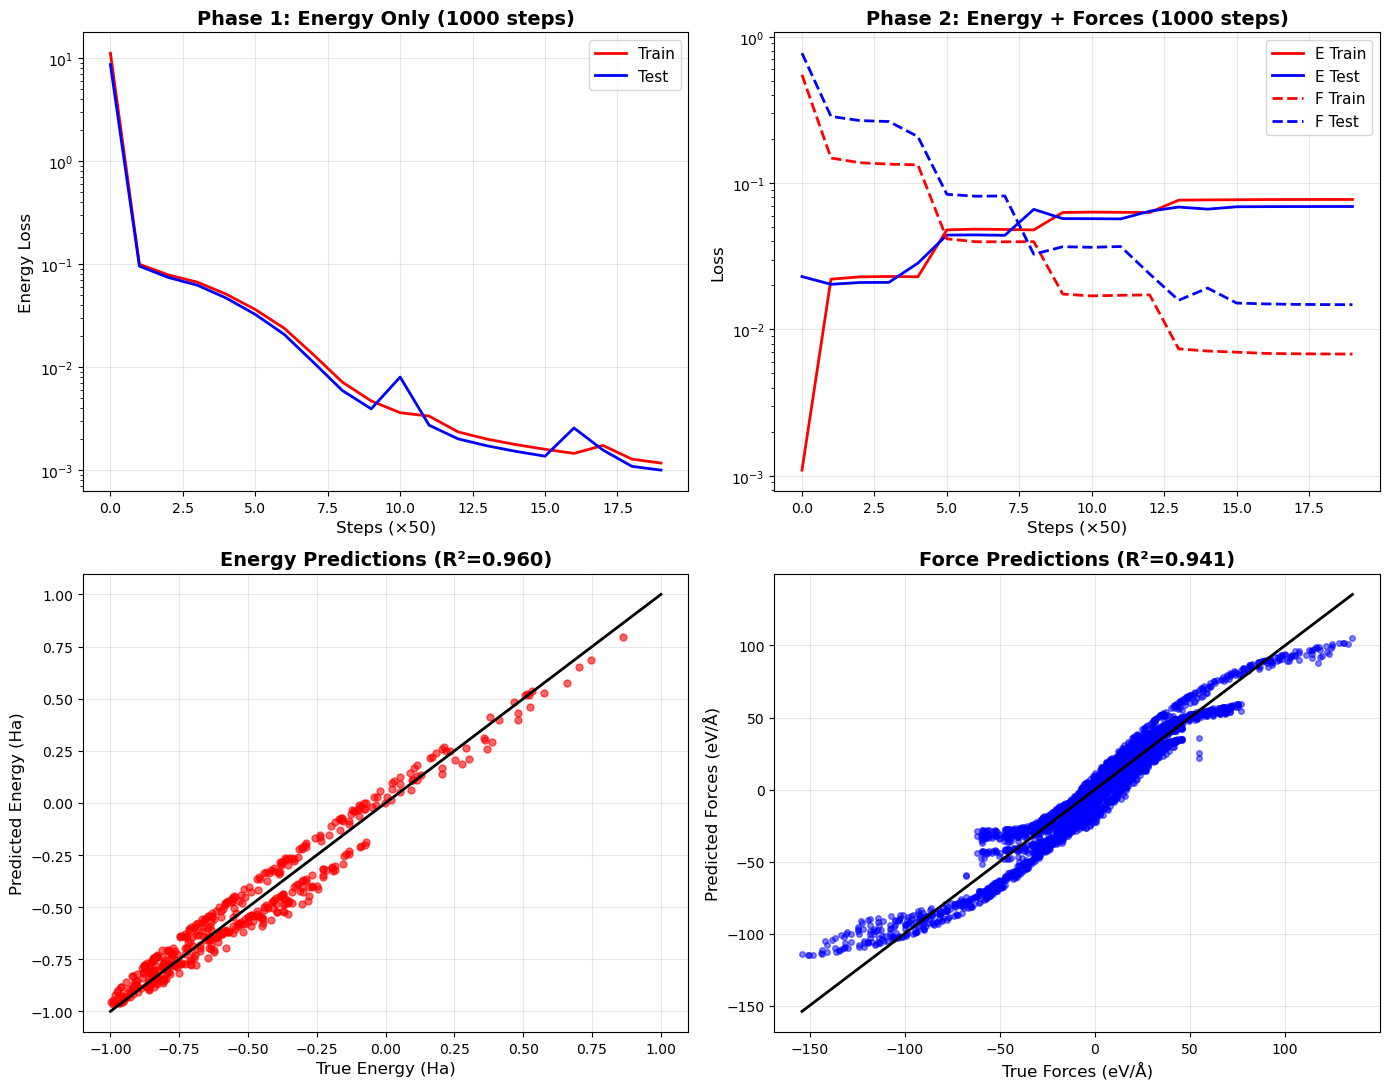

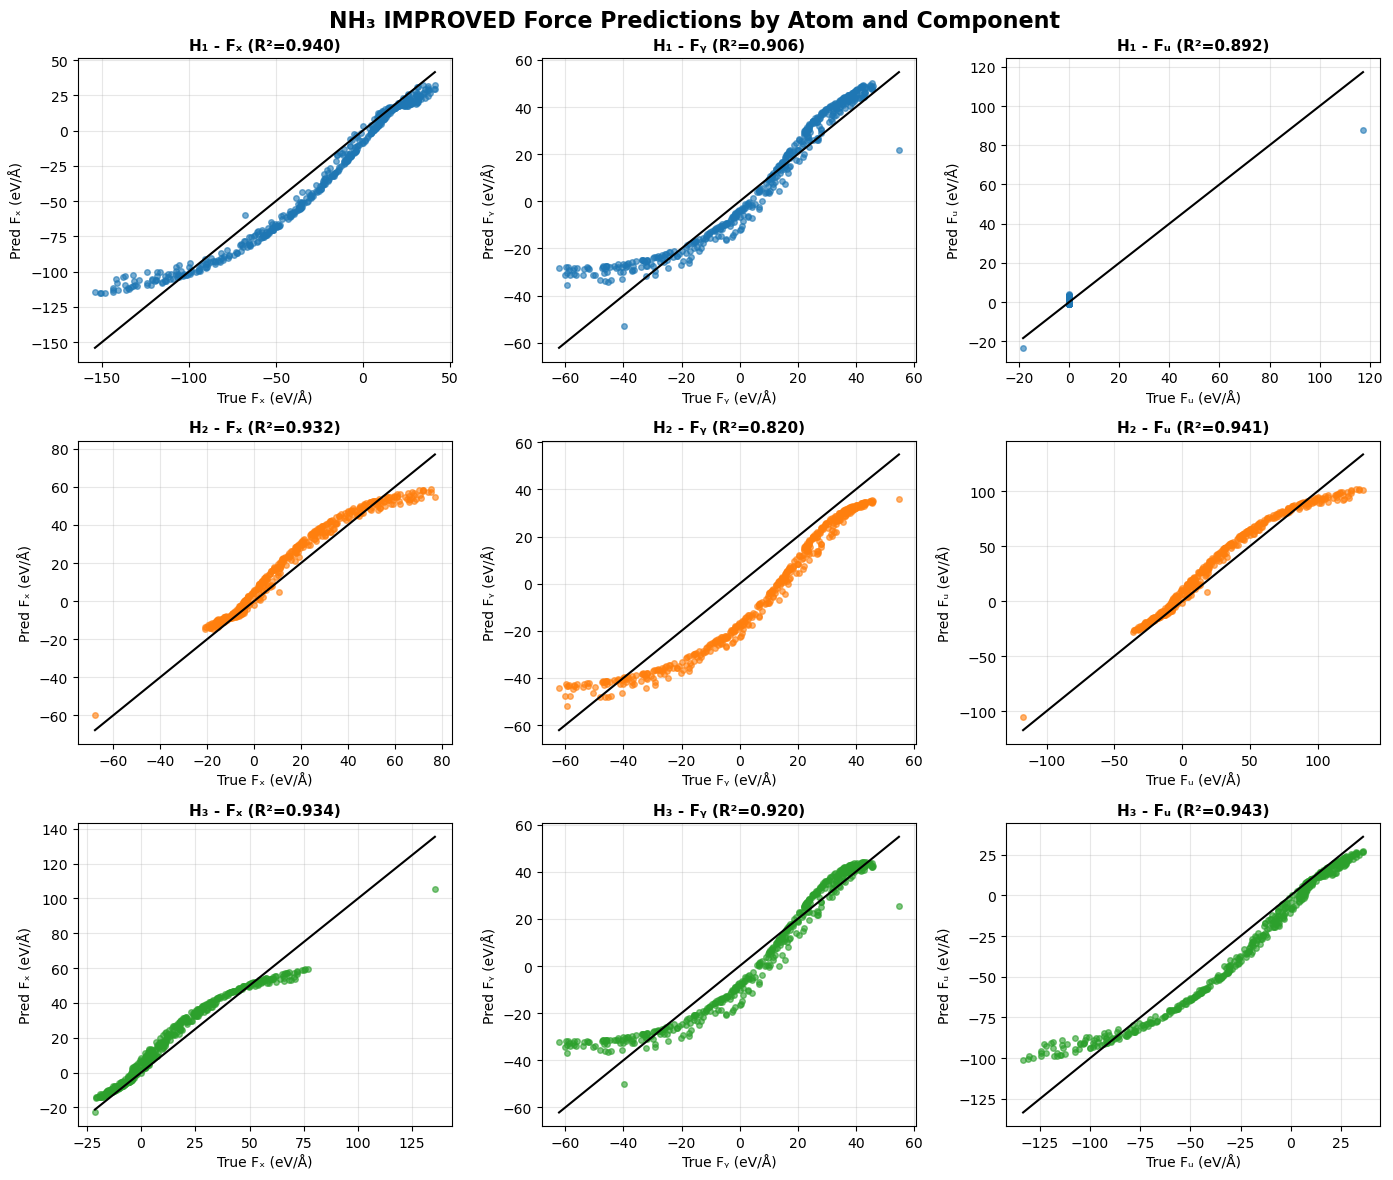


✓ IMPROVED Graph-based equivariant QML for NH₃ complete!
✓ Extended training with curriculum learning
✓ Adaptive learning rates and Huber loss for robustness
✓ Deeper circuit (depth=6) for more expressivity


In [1]:
import pennylane as qml
import numpy as np

import jax
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

from jax import numpy as jnp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

#############################################################################################
# IMPROVED GRAPH-BASED EQUIVARIANT QML FOR NH3
# Enhancements:
# 1. More training iterations with curriculum learning
# 2. Adaptive learning rate scheduling
# 3. Huber loss for robust force predictions
# 4. Better gradient handling
# 5. Deeper circuit with more expressivity
#############################################################################################

print(f"\n{'='*70}")
print(f"NH₃ - IMPROVED Graph-Based Equivariant QML")
print(f"{'='*70}")
print(f"Improvements: Curriculum learning, adaptive LR, Huber loss")
print(f"{'='*70}\n")

# Enhanced architecture
n_qubits = 6  # 3 bonds × 2 qubits per bond
depth = 6     # Increased depth for more expressivity

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="jax", diff_method="backprop")
def graph_qnn(positions, params):
    """
    Enhanced graph-based QNN for NH3 with deeper architecture.
    """
    weights = params["weights"]  # (depth, n_qubits, 3)
    
    # N is at index 0, H atoms at indices 1, 2, 3
    N_pos = positions[0]
    H_positions = positions[1:]  # (3, 3)
    
    # Compute 3 bond vectors and distances
    bonds = H_positions - N_pos[None, :]  # (3, 3)
    distances = jnp.linalg.norm(bonds, axis=1)  # (3,)
    
    # Normalized bond vectors
    bonds_norm = bonds / (distances[:, None] + 1e-12)
    
    # Compute angles between bonds
    def compute_angle(v1, v2):
        cos_angle = jnp.dot(v1, v2) / (jnp.linalg.norm(v1) * jnp.linalg.norm(v2) + 1e-12)
        return jnp.arccos(jnp.clip(cos_angle, -1.0, 1.0))
    
    angle_01 = compute_angle(bonds[0], bonds[1])
    angle_02 = compute_angle(bonds[0], bonds[2])
    angle_12 = compute_angle(bonds[1], bonds[2])
    
    # Initialize qubits with variety
    for i in range(n_qubits):
        qml.RY(0.5 + 0.1 * i, wires=i)
        qml.RZ(0.3 * i, wires=i)
    
    # Apply enhanced layers
    for layer in range(depth):
        # === Distance encoding on qubit pairs ===
        # Bond 0 (N-H1): qubits 0, 1
        qml.RY(weights[layer, 0, 0] * distances[0], wires=0)
        qml.RY(weights[layer, 1, 0] * distances[0], wires=1)
        qml.RZ(weights[layer, 0, 1] * distances[0], wires=0)
        
        # Bond 1 (N-H2): qubits 2, 3
        qml.RY(weights[layer, 2, 0] * distances[1], wires=2)
        qml.RY(weights[layer, 3, 0] * distances[1], wires=3)
        qml.RZ(weights[layer, 2, 1] * distances[1], wires=2)
        
        # Bond 2 (N-H3): qubits 4, 5
        qml.RY(weights[layer, 4, 0] * distances[2], wires=4)
        qml.RY(weights[layer, 5, 0] * distances[2], wires=5)
        qml.RZ(weights[layer, 4, 1] * distances[2], wires=4)
        
        # === Within-bond entanglement ===
        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[2, 3])
        qml.CNOT(wires=[4, 5])
        
        # === Angular encoding (cross-bond geometry) ===
        qml.RZ(weights[layer, 0, 2] * angle_01, wires=0)
        qml.RZ(weights[layer, 2, 2] * angle_01, wires=2)
        
        qml.RZ(weights[layer, 1, 2] * angle_02, wires=0)
        qml.RZ(weights[layer, 4, 2] * angle_02, wires=4)
        
        qml.RZ(weights[layer, 3, 1] * angle_12, wires=2)
        qml.RZ(weights[layer, 5, 1] * angle_12, wires=4)
        
        # === Cross-bond entanglement (graph structure) ===
        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[3, 4])
        qml.CNOT(wires=[5, 0])
        
        # === Additional variational layers ===
        for i in range(n_qubits):
            qml.RY(weights[layer, i, 1], wires=i)
        
        # Reverse entanglement pattern
        if layer % 2 == 0:
            qml.CNOT(wires=[2, 1])
            qml.CNOT(wires=[4, 3])
            qml.CNOT(wires=[0, 5])
        
        # Final rotations
        for i in range(n_qubits):
            qml.RZ(weights[layer, i, 2], wires=i)
    
    # Measure all qubits
    return qml.expval(qml.sum(*(qml.PauliZ(i) for i in range(n_qubits))))

#############################################################################################
# HELPER: HUBER LOSS
#############################################################################################

def huber_loss(residual, delta=1.0):
    """Huber loss for robust regression."""
    abs_r = jnp.abs(residual)
    quad = 0.5 * residual**2
    lin = delta * (abs_r - 0.5 * delta)
    return jnp.where(abs_r <= delta, quad, lin)

#############################################################################################
# DATA LOADING
#############################################################################################

energy = np.load("eqnn_force_field_data_nh3_new/Energy.npy")
forces = np.load("eqnn_force_field_data_nh3_new/Forces.npy")
positions = np.load("eqnn_force_field_data_nh3_new/Positions.npy")

print(f"Data: {len(positions)} configurations")
print(f"Positions shape: {positions.shape}")
print(f"Forces shape: {forces.shape}\n")

# Normalize energies
energy_scaler = MinMaxScaler((-1, 1))
if energy.ndim == 1:
    energy = energy.reshape(-1, 1)
energy_scaled = energy_scaler.fit_transform(energy).flatten()

# Normalize forces
forces_H = forces[:, 1:, :]  # (N, 3, 3)
force_scaler = MinMaxScaler((-1, 1))

forces_flat = forces_H.reshape(-1, 1)
forces_scaled_flat = force_scaler.fit_transform(forces_flat).flatten()
forces_scaled = forces_scaled_flat.reshape(forces_H.shape)

print(f"Energy scaled: [{energy_scaled.min():.4f}, {energy_scaled.max():.4f}]")
print(f"Forces scaled: [{forces_scaled.min():.4f}, {forces_scaled.max():.4f}]\n")

# Train/test split
np.random.seed(42)
indices_train = np.random.choice(len(positions), size=int(0.8 * len(positions)), replace=False)
indices_test = np.setdiff1d(np.arange(len(positions)), indices_train)

E_train = energy_scaled[indices_train]
E_test = energy_scaled[indices_test]
F_train = forces_scaled[indices_train]
F_test = forces_scaled[indices_test]
pos_train = jnp.array(positions[indices_train])
pos_test = jnp.array(positions[indices_test])

print(f"Train: {len(indices_train)}, Test: {len(indices_test)}\n")

#############################################################################################
# PHASE 1: ENERGY ONLY (EXTENDED)
#############################################################################################

from jax.example_libraries import optimizers

vec_qnn = jax.vmap(graph_qnn, (0, None), 0)

@jax.jit
def energy_loss(params, loss_data):
    positions, E_target = loss_data
    E_pred = vec_qnn(positions, params)
    return jnp.mean((E_pred - E_target) ** 2)

def train_step_energy(step_i, opt_state, loss_data):
    net_params = get_params(opt_state)
    loss, grads = jax.value_and_grad(energy_loss)(net_params, loss_data)
    
    # Gradient health check
    grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree.leaves(grads) if g is not None))
    
    # Adaptive gradient clipping
    max_grad = 5.0
    if grad_norm > max_grad:
        grads = jax.tree.map(lambda g: g * (max_grad / grad_norm) if g is not None else g, grads)
        grad_norm = max_grad
    
    return float(loss), float(grad_norm), opt_update(step_i, grads, opt_state)

# Initialize with better scaling
np.random.seed(42)
weights = jnp.array(np.random.normal(0, 0.05, (depth, n_qubits, 3)))  # Smaller init
net_params = {"weights": weights}

print(f"{'='*70}")
print(f"PHASE 1: Training ENERGY only (EXTENDED)")
print(f"{'='*70}\n")

# Start with higher learning rate
lr = 0.02
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(net_params)

energy_losses = []
n_energy_steps = 1000  # More steps

for step in range(n_energy_steps):
    # Learning rate decay
    if step == 500:
        lr = 0.01
        opt_init, opt_update, get_params = optimizers.adam(lr)
        opt_state = opt_init(get_params(opt_state))
    if step == 800:
        lr = 0.005
        opt_init, opt_update, get_params = optimizers.adam(lr)
        opt_state = opt_init(get_params(opt_state))
    
    loss_data = (pos_train, E_train)
    loss, grad_norm, opt_state = train_step_energy(step, opt_state, loss_data)
    
    if step % 50 == 0:
        test_params = get_params(opt_state)
        E_pred_test = np.array(vec_qnn(pos_test, test_params))
        test_loss = np.mean((E_pred_test - E_test) ** 2)
        
        energy_losses.append([loss, test_loss])
        
        print(f"  Step {step:4d} | Train: {loss:.6f} | Test: {test_loss:.6f} | "
              f"GradNorm: {grad_norm:.4f} | LR: {lr:.4f}")

print(f"\nEnergy training complete!\n")

trained_params = get_params(opt_state)

E_pred_train = np.array(vec_qnn(pos_train, trained_params))
E_pred_test = np.array(vec_qnn(pos_test, trained_params))

E_train_r2 = 1 - np.var(E_pred_train - E_train) / np.var(E_train)
E_test_r2 = 1 - np.var(E_pred_test - E_test) / np.var(E_test)

print(f"Energy R² (train): {E_train_r2:.4f}")
print(f"Energy R² (test):  {E_test_r2:.4f}\n")

#############################################################################################
# PHASE 2: ADD FORCES WITH CURRICULUM LEARNING
#############################################################################################

print(f"{'='*70}")
print(f"PHASE 2: Adding FORCES (CURRICULUM LEARNING)")
print(f"{'='*70}\n")

def energy_single(coords, params):
    return graph_qnn(coords, params)

def force_single(coords, params):
    grad_fn = jax.grad(energy_single, argnums=0)
    gradient = grad_fn(coords, params)
    return -gradient

vec_force = jax.vmap(force_single, (0, None), 0)

@jax.jit
def combined_loss(params, loss_data, lambda_E, lambda_F, huber_delta):
    positions, E_target, F_target = loss_data
    
    # Energy loss (MSE)
    E_pred = vec_qnn(positions, params)
    E_loss = jnp.mean((E_pred - E_target) ** 2)
    
    # Force loss (Huber for robustness)
    F_pred_full = vec_force(positions, params)
    F_pred_H = F_pred_full[:, 1:, :]
    
    F_residual = F_pred_H - F_target
    F_loss = jnp.mean(huber_loss(F_residual, delta=huber_delta))
    
    # Safety checks
    E_loss = jnp.where(jnp.isnan(E_loss), 1.0, E_loss)
    F_loss = jnp.where(jnp.isnan(F_loss), 1.0, F_loss)
    
    total_loss = lambda_E * E_loss + lambda_F * F_loss
    
    return total_loss, (E_loss, F_loss)

def train_step_combined(step_i, opt_state, loss_data, lambda_E, lambda_F, huber_delta):
    net_params = get_params(opt_state)
    
    def loss_with_params(p):
        return combined_loss(p, loss_data, lambda_E, lambda_F, huber_delta)
    
    (loss, (E_loss, F_loss)), grads = jax.value_and_grad(loss_with_params, has_aux=True)(net_params)
    
    grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree.leaves(grads) if g is not None))
    
    # Adaptive clipping
    max_grad = 5.0
    if grad_norm > max_grad:
        grads = jax.tree.map(lambda g: g * (max_grad / grad_norm) if g is not None else g, grads)
        grad_norm = max_grad
    
    return float(loss), float(E_loss), float(F_loss), float(grad_norm), opt_update(step_i, grads, opt_state)

# Curriculum parameters
lr = 0.01
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(trained_params)

combined_losses = []
n_force_steps = 1000

print("Training with energy + forces (curriculum learning):")

for step in range(n_force_steps):
    # Curriculum: gradually increase force weight
    if step < 200:
        lambda_E = 3.0
        lambda_F = 0.5
        huber_delta = 2.0
    elif step < 400:
        lambda_E = 2.0
        lambda_F = 1.0
        huber_delta = 1.5
    elif step < 600:
        lambda_E = 1.5
        lambda_F = 1.5
        huber_delta = 1.0
    else:
        lambda_E = 1.0
        lambda_F = 2.0
        huber_delta = 0.8
    
    # Learning rate schedule
    if step == 400:
        lr = 0.005
        opt_init, opt_update, get_params = optimizers.adam(lr)
        opt_state = opt_init(get_params(opt_state))
    if step == 700:
        lr = 0.002
        opt_init, opt_update, get_params = optimizers.adam(lr)
        opt_state = opt_init(get_params(opt_state))
    
    loss_data = (pos_train, E_train, F_train)
    loss, E_loss, F_loss, grad_norm, opt_state = train_step_combined(
        step, opt_state, loss_data, lambda_E, lambda_F, huber_delta
    )
    
    if step % 50 == 0:
        test_params = get_params(opt_state)
        E_pred_test_val = np.array(vec_qnn(pos_test, test_params))
        F_pred_test_val = np.array(vec_force(pos_test, test_params))[:, 1:, :]
        
        E_test_loss = np.mean((E_pred_test_val - E_test) ** 2)
        F_test_loss = np.mean((F_pred_test_val - F_test) ** 2)
        
        combined_losses.append([E_loss, E_test_loss, F_loss, F_test_loss])
        
        print(f"  Step {step:4d} | E: {E_loss:.4f}/{E_test_loss:.4f} | "
              f"F: {F_loss:.4f}/{F_test_loss:.4f} | GradNorm: {grad_norm:.4f} | "
              f"λE/λF: {lambda_E:.1f}/{lambda_F:.1f}")

print(f"\n{'='*70}")
print("Training complete!")
print(f"{'='*70}\n")

#############################################################################################
# FINAL EVALUATION
#############################################################################################

final_params = get_params(opt_state)

E_pred_all = np.array(vec_qnn(jnp.array(positions), final_params))
F_pred_all = np.array(vec_force(jnp.array(positions), final_params))
F_pred_all_H = F_pred_all[:, 1:, :]

print("Post-correction...")

# Energy correction
def corr_E(E, a, b, c):
    return a * E**2 + b * E + c

try:
    popt_E, _ = curve_fit(corr_E, E_pred_all[indices_train], E_train, maxfev=10000)
    E_pred_corr = corr_E(E_pred_all, *popt_E)
    print(f"Energy: a={popt_E[0]:.4f}, b={popt_E[1]:.4f}, c={popt_E[2]:.4f}")
except:
    E_pred_corr = E_pred_all
    print("Energy: No correction")

# Force correction
try:
    F_pred_flat = F_pred_all_H[indices_train].flatten().reshape(-1, 1)
    F_true_flat = F_train.flatten().reshape(-1, 1)
    
    lr_model = LinearRegression()
    lr_model.fit(F_pred_flat, F_true_flat)
    
    F_pred_all_flat = F_pred_all_H.reshape(-1, 1)
    F_pred_corr_flat = lr_model.predict(F_pred_all_flat)
    F_pred_corr = F_pred_corr_flat.reshape(F_pred_all_H.shape)
    
    print(f"Force: slope={lr_model.coef_[0][0]:.4f}, intercept={lr_model.intercept_[0]:.4f}")
except:
    F_pred_corr = F_pred_all_H
    print("Force: No correction")

# Inverse transform
E_pred_final = energy_scaler.inverse_transform(E_pred_corr.reshape(-1, 1)).flatten()
E_true = energy_scaler.inverse_transform(energy_scaled.reshape(-1, 1)).flatten()

F_pred_corr_flat = F_pred_corr.reshape(-1, 1)
F_pred_final_flat = force_scaler.inverse_transform(F_pred_corr_flat)
F_pred_final = F_pred_final_flat.reshape(F_pred_corr.shape)

F_true = forces[:, 1:, :]

# Metrics
E_mae = np.mean(np.abs(E_pred_final[indices_test] - E_true[indices_test]))
E_rmse = np.sqrt(np.mean((E_pred_final[indices_test] - E_true[indices_test]) ** 2))
E_r2 = 1 - np.sum((E_pred_final[indices_test] - E_true[indices_test])**2) / np.sum((E_true[indices_test] - E_true[indices_test].mean())**2)

F_test_true = F_true[indices_test].flatten()
F_test_pred = F_pred_final[indices_test].flatten()

F_mae = np.mean(np.abs(F_test_pred - F_test_true))
F_rmse = np.sqrt(np.mean((F_test_pred - F_test_true) ** 2))
F_r2 = 1 - np.sum((F_test_pred - F_test_true)**2) / np.sum((F_test_true - F_test_true.mean())**2)

print(f"\n{'='*70}")
print(f"FINAL RESULTS")
print(f"{'='*70}")
print(f"Energy:")
print(f"  MAE:  {E_mae:.6f} Ha ({E_mae*27.2114:.3f} eV)")
print(f"  RMSE: {E_rmse:.6f} Ha ({E_rmse*27.2114:.3f} eV)")
print(f"  R²:   {E_r2:.4f}")
print(f"\nForces (all components, all H atoms):")
print(f"  MAE:  {F_mae:.4f} eV/Å")
print(f"  RMSE: {F_rmse:.4f} eV/Å")
print(f"  R²:   {F_r2:.4f}")

# Per-component metrics
print(f"\nPer-component Force R²:")
for atom_idx in range(3):
    for comp_idx in range(3):
        F_true_comp = F_true[indices_test, atom_idx, comp_idx]
        F_pred_comp = F_pred_final[indices_test, atom_idx, comp_idx]
        r2 = 1 - np.sum((F_pred_comp - F_true_comp)**2) / np.sum((F_true_comp - F_true_comp.mean())**2)
        comp_name = ['x', 'y', 'z'][comp_idx]
        print(f"  H{atom_idx+1}-F{comp_name}: {r2:.4f}")

print(f"{'='*70}\n")

#############################################################################################
# PLOTS
#############################################################################################

fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# Phase 1
energy_losses = np.array(energy_losses)
axes[0, 0].plot(energy_losses[:, 0], 'r-', lw=2, label='Train')
axes[0, 0].plot(energy_losses[:, 1], 'b-', lw=2, label='Test')
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlabel('Steps (×50)', fontsize=12)
axes[0, 0].set_ylabel('Energy Loss', fontsize=12)
axes[0, 0].set_title('Phase 1: Energy Only (1000 steps)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Phase 2
if len(combined_losses) > 0:
    combined_losses = np.array(combined_losses)
    axes[0, 1].plot(combined_losses[:, 0], 'r-', lw=2, label='E Train')
    axes[0, 1].plot(combined_losses[:, 1], 'b-', lw=2, label='E Test')
    axes[0, 1].plot(combined_losses[:, 2], 'r--', lw=2, label='F Train')
    axes[0, 1].plot(combined_losses[:, 3], 'b--', lw=2, label='F Test')
    axes[0, 1].set_yscale('log')
    axes[0, 1].set_xlabel('Steps (×50)', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].set_title('Phase 2: Energy + Forces (1000 steps)', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

# Energy predictions
axes[1, 0].plot(E_true[indices_test], E_pred_final[indices_test], 'ro', alpha=0.6, ms=5)
axes[1, 0].plot([E_true.min(), E_true.max()], [E_true.min(), E_true.max()], 'k-', lw=2)
axes[1, 0].set_xlabel('True Energy (Ha)', fontsize=12)
axes[1, 0].set_ylabel('Predicted Energy (Ha)', fontsize=12)
axes[1, 0].set_title(f'Energy Predictions (R²={E_r2:.3f})', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Force predictions
axes[1, 1].plot(F_test_true, F_test_pred, 'bo', alpha=0.5, ms=4)
axes[1, 1].plot([F_test_true.min(), F_test_true.max()], 
                [F_test_true.min(), F_test_true.max()], 'k-', lw=2)
axes[1, 1].set_xlabel('True Forces (eV/Å)', fontsize=12)
axes[1, 1].set_ylabel('Predicted Forces (eV/Å)', fontsize=12)
axes[1, 1].set_title(f'Force Predictions (R²={F_r2:.3f})', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('NH3_improved_main.png', dpi=300, bbox_inches='tight')
plt.show()

# Per-component plot
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
fig.suptitle('NH₃ IMPROVED Force Predictions by Atom and Component', fontsize=16, fontweight='bold')

atom_names = ['H₁', 'H₂', 'H₃']
component_names = ['Fₓ', 'Fᵧ', 'Fᵤ']

for atom_idx in range(3):
    for comp_idx in range(3):
        ax = axes[atom_idx, comp_idx]
        
        F_true_comp = F_true[indices_test, atom_idx, comp_idx]
        F_pred_comp = F_pred_final[indices_test, atom_idx, comp_idx]
        
        ax.plot(F_true_comp, F_pred_comp, 'o', alpha=0.6, ms=4, color=f'C{atom_idx}')
        ax.plot([F_true_comp.min(), F_true_comp.max()], 
                [F_true_comp.min(), F_true_comp.max()], 'k-', lw=1.5)
        
        r2 = 1 - np.sum((F_pred_comp - F_true_comp)**2) / np.sum((F_true_comp - F_true_comp.mean())**2)
        
        ax.set_xlabel(f'True {component_names[comp_idx]} (eV/Å)', fontsize=10)
        ax.set_ylabel(f'Pred {component_names[comp_idx]} (eV/Å)', fontsize=10)
        ax.set_title(f'{atom_names[atom_idx]} - {component_names[comp_idx]} (R²={r2:.3f})', 
                    fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('NH3_improved_components.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ IMPROVED Graph-based equivariant QML for NH₃ complete!")
print("✓ Extended training with curriculum learning")
print("✓ Adaptive learning rates and Huber loss for robustness")
print("✓ Deeper circuit (depth=6) for more expressivity")